In [1]:
#import all required packages
import os
import numpy as np
import re
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join, vstack
from astropy.coordinates import SkyCoord, search_around_sky, Angle

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [2]:
#new functions needed for this notebook
from astropy.coordinates.matching import _get_cartesian_kdtree

from regions import read_ds9, write_ds9, CircleSkyRegion


In [3]:
#import configuration for selected file
from config import wavelength, segdetsig, finddetsig, bkgbox #import additional common paramters
from config import dpath, dpathalt, ds9path #import additional common paramters

from config import *

In [4]:
#change directory to where data is
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

In [5]:
#pick a field to start with so we can get the table structure. 
#The files for the field cannot be empty or an error message will display
startfield=FieldA.name

if os.path.exists(startfield+'_'+str(wavelength)+'um_daoCat.dat'):
    mastercatDAO=ascii.read(FieldA.name+'_'+str(wavelength)+'um_daoCat.dat')
else:
    print('Error... Must pick another file to start with')
    
if os.path.exists(startfield+'_'+str(wavelength)+'um_segCat.dat'):
    mastercatSEG=ascii.read(FieldA.name+'_'+str(wavelength)+'um_segCat.dat')
else:
    print('Error... Must pick another file to start with')


In [6]:
#loop through all the saved photometry tables for individual fields and append them together
for info in field._registry:
    filename=info.filename
    name=info.name
    
    #print('\nLoading in photometry data from field: ', name)
    
    if name is not startfield:
        
        if os.path.exists(name+'_'+str(wavelength)+'um_daoCat.dat'):
            newtab1=ascii.read(name+'_'+str(wavelength)+'um_daoCat.dat')
            
            mastercatDAO=vstack([mastercatDAO,newtab1])
            
            
        if os.path.exists(name+'_'+str(wavelength)+'um_segCat.dat'):
            newtab2=ascii.read(name+'_'+str(wavelength)+'um_segCat.dat')
            
            mastercatSEG=vstack([mastercatSEG,newtab2])

#print the table sizes to get source counts
print('Raw number of seg map sources: ', len(mastercatSEG))
print('Raw number of daofind sources: ', len(mastercatDAO))

Raw number of seg map sources:  648
Raw number of daofind sources:  365


In [7]:
#add 'master' ids in the combined tables
mastercatSEG['Master_id']=np.linspace(1,len(mastercatSEG),len(mastercatSEG),dtype=np.int)
mastercatDAO['Master_id']=np.linspace(1,len(mastercatDAO),len(mastercatDAO),dtype=np.int)

In [8]:
#Source coordinates need to be in the form of skycoord objects. Ascii tables save as strings so this code puts them back in the right form. 
if mastercatSEG is not None:
    sourcecoords=mastercatSEG['sky_centroid']
else:
    sourcecoords=[]
scseg=[]

for coord in sourcecoords:
    pos=coord.find(",")
    ra=coord[:pos]
    dec=coord[pos+1:]
    scobj=SkyCoord(ra,dec,unit=u.deg)
    scseg.append(scobj)

if mastercatSEG is not None:
    mastercatSEG['skycoords']=scseg
    scseg=mastercatSEG['skycoords']

sourcecoords=mastercatDAO['sky_centroid']
scdao=[]

for coord in sourcecoords:
    pos=coord.find(",")
    ra=coord[:pos]
    dec=coord[pos+1:]
    scobj=SkyCoord(ra,dec,unit=u.deg)
    scdao.append(scobj)
    
mastercatDAO['skycoords']=scdao
scdao=mastercatDAO['skycoords']

In [9]:
#print the seg table
mastercatSEG

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,skycoords,aperture_sum_3.5as,aperture_sum_err_3.5as,aperture_sum_3.75as,aperture_sum_err_3.75as,aperture_sum_4.0as,aperture_sum_err_4.0as,aperture_sum_4.25as,aperture_sum_err_4.25as,aperture_sum_4.5as,aperture_sum_err_4.5as,aperture_sum_4.75as,aperture_sum_err_4.75as,aperture_sum_5.0as,aperture_sum_err_5.0as,aperture_sum_5.25as,aperture_sum_err_5.25as,aperture_sum_5.5as,aperture_sum_err_5.5as,aperture_sum_5.75as,aperture_sum_err_5.75as,aperture_sum_6.0as,aperture_sum_err_6.0as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,pixApArea,pixAnnArea,aper_snr_6as,aper_sum_bkgsub_3.5as,aper_sum_bkgsub_3.75as,aper_sum_bkgsub_4.0as,aper_sum_bkgsub_4.25as,aper_sum_bkgsub_4.5as,aper_sum_bkgsub_4.75as,aper_sum_bkgsub_5.0as,aper_sum_bkgsub_5.25as,aper_sum_bkgsub_5.5as,aper_sum_bkgsub_5.75as,aper_sum_bkgsub_6.0as,aper_sum_bkgsub_10as,aper_snr_3.5as,aper_snr_3.75as,aper_snr_4.0as,aper_snr_4.25as,aper_snr_4.5as,aper_snr_4.75as,aper_snr_5.0as,aper_snr_5.25as,aper_snr_5.5as,aper_snr_5.75as,aper_snr_6.0as,aper_snr_10as,aper_snr_max,Field,wv,Master_id
,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,str38,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,int32,int32
1,185.7,53.38,"266.3251439751818,-29.07810767850448",0.02809,0.005636,0.2987,53,2.184,1.684,-11.8,0.2156,0.05716,0.3465,0.6365,0.2287,1.297,4.592,8.889,0.4441,2.771,3.334,0.129,0.00554,0.005515,0.001103,5.136,"266.3251439751818,-29.07810767850448",4.064191264362414,0.1436035028599071,4.40512876606941,0.15401058357236383,4.733781464724758,0.1644266879972215,5.045941218469983,0.17484920342436022,5.364082426069148,0.18527479381496464,5.670884510094932,0.19575554331244469,5.97927970441601,0.20629698348008146,6.295254873046549,0.21687134343761783,6.6347027222923955,0.22753232244226068,6.977544186990841,0.23830716271689145,7.320475242706701,0.24914123593798546,11.219713707981342,0.44093325418505575,-0.00110152259003371,-0.001460585809972832,7.531689550356361,0.24914123593798546,0.0,191.747595156624,830.9062456787041,13.60132719014324,4.1360627996043124,4.487634354995059,4.827654490346829,5.151915063801148,5.482890474122081,5.803260143882305,6.125956306950496,6.456965827340819,6.8121814113591235,7.171523993842698,7.531689550356361,11.806420118119286,10.509677032309682,10.952170609196168,11.338304125072453,11.663974357013618,11.9839265226056,12.259765831621918,12.521330180677717,12.781967834534921,13.070097083751321,13.34450623089316,13.60132719014324,13.87950963728634,13.87950963728634,C7FieldA,37,1
2,96.69,145.6,"266.3468746469096,-29.05842545863498",0.02408,0.06171,4.505,73,2.511,2.252,16.57,0.1617,-0.02114,0.1941,0.4428,0.1034,1.115,5.616,10.93,0.4729,2.528,3.961,0.1517,0.06087,0.06079,0.005422,1.849,"266.3468746469096,-29.05842545863498",7.618546933691713,0.14347148154999054,8.625324950686224,0.15372123618347858,9.668407553734529,0.16397025846672134,10.786174535854155,0.17421518289963098,11.974505611216939,0.18445762139130267,13.209936676318073,0.1947010

In [10]:
#print the dao table
mastercatDAO

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,sky_centroid,skycoords,aperture_sum_3.5as,aperture_sum_err_3.5as,aperture_sum_3.75as,aperture_sum_err_3.75as,aperture_sum_4.0as,aperture_sum_err_4.0as,aperture_sum_4.25as,aperture_sum_err_4.25as,aperture_sum_4.5as,aperture_sum_err_4.5as,aperture_sum_4.75as,aperture_sum_err_4.75as,aperture_sum_5.0as,aperture_sum_err_5.0as,aperture_sum_5.25as,aperture_sum_err_5.25as,aperture_sum_5.5as,aperture_sum_err_5.5as,aperture_sum_5.75as,aperture_sum_err_5.75as,aperture_sum_6.0as,aperture_sum_err_6.0as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,pixApArea,pixAnnArea,aper_snr_6as,aper_sum_bkgsub_3.5as,aper_sum_bkgsub_3.75as,aper_sum_bkgsub_4.0as,aper_sum_bkgsub_4.25as,aper_sum_bkgsub_4.5as,aper_sum_bkgsub_4.75as,aper_sum_bkgsub_5.0as,aper_sum_bkgsub_5.25as,aper_sum_bkgsub_5.5as,aper_sum_bkgsub_5.75as,aper_sum_bkgsub_6.0as,aper_sum_bkgsub_10as,aper_snr_3.5as,aper_snr_3.75as,aper_snr_4.0as,aper_snr_4.25as,aper_snr_4.5as,aper_snr_4.75as,aper_snr_5.0as,aper_snr_5.25as,aper_snr_5.5as,aper_snr_5.75as,aper_snr_6.0as,aper_snr_10as,aper_snr_max,Field,wv,Master_id
,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,str38,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,int32,int32
1,157.2,43.4,0.4876,-0.4952,0.2805,25,0,0.03301,1.113,-0.1162,"266.33210640119506,-29.08023670086261","266.33210640119506,-29.08023670086261",-0.818896477090534,0.18023785756538827,-0.9538808496730133,0.19284670402119283,-1.1004801193802562,0.20544685544205665,-1.252200663422857,0.21806460368509267,-1.4230365802714813,0.2306878648662847,-1.6219165822153823,0.24332092359947158,-1.8246607858986794,0.25595978721440477,-2.0323968833666024,0.26860408641310407,-2.2415483152043247,0.281263164988438,-2.4518121226690828,0.29393630333806736,-2.6558265752869294,0.30661796211562553,-7.1284307519655705,0.5086466618450843,-0.012176643125712872,-0.012363214480894684,-0.3209845388510494,0.30661796211562553,0.0,191.747595156624,830.9062456787041,-0.5225128823299975,-0.02440161746999143,-0.041833179190247705,-0.0627725476309763,-0.0807261000027714,-0.1096879347762988,-0.15858676424081164,-0.20324270504042907,-0.2447834492203815,-0.27963243736584226,-0.3074867107340468,-0.3209845388510494,-0.6427584285325696,-0.055345251993435755,-0.09123737468179109,-0.13189188688279685,-0.16365567665387265,-0.21485438475839677,-0.30049993344366266,-0.3729512851252234,-0.43540765437020723,-0.48255328549951926,-0.5151804068654298,-0.5225128823299975,-0.7035289892966059,-0.055345251993435755,C7FieldA,37,1
2,213.4,148.9,0.4518,-0.1732,0.8181,25,0,0.1442,1.076,-0.07969,"266.3183989918721,-29.057733937455602","266.3183989918721,-29.057733937455602",18.734297719120754,0.14816358805970256,21.20770984238869,0.15874357538772235,23.801396378109168,0.16932338698122978,26.508367632892945,0.17990310150893593,29.323747257271005,0.19048076641502518,32.258784999887325,0.20105608012153878,35.28986975428329,0.2116294175824651,38.37882781122658,0.22220078568287677,41.52228558021345,0.23277124067855806,44.73949176145831,0.2433410285109194,48.03156530191408,0.2539122179038373,112.74481233385644,0.42298183947725354,0.11633483320474625,0.13586801740255652,25.724640801957023,0.2539122179038373,0.11633483320474622,191.747595156624,830.9062456787041,4.8818384427350585,11.143747021218697,12.494067459592966,13.887207711461585,15.316178083435325,16.77610222604516

In [11]:
#source coords should be skycoord objects, sep should be an angular quantity e.g., 4*u.arcsec
def remove_duplicates(mastercat, sep):
	sourcecoords=mastercat['skycoords']

	#create KD Tree
	kdt=_get_cartesian_kdtree(sourcecoords)
    
	#search radius
	r = (2 * np.sin(Angle(sep) / 2.0)).value #search radius
    
	#initialize counter
	counter=0
    
	#create array to hold matches
	matchstore=np.zeros(len(mastercat),dtype=np.int)
    
	#loop through and find all matching sources within crossmatch radius
	for i, matches in enumerate(kdt.query_ball_tree(kdt,r)):
		if len(matches)>1:
			counter+=1
			
			for match in matches:
				if match!=matches[(match+1)%len(matches)]:
					matchstore[match]=matches[(match+1)%len(matches)]+1
				else:
					matchstore[match]=matches[(match+2)%len(matches)]+1

	#store possible crossmatches
	mastercat['selfXmatch']=matchstore
	print('number of likely duplicates: ', counter)
    
	#create keep and remove lists
	keep=[]
	remove=[]
    
	#loop through and mark sources to keep and remove based on which has the greater aperture photometry snr
	for row in mastercat:
		if row['selfXmatch']>0:
			#print(row['Master_id'])
			idx1 = row['Master_id']
			idx2 = row['selfXmatch']
			
			row1=mastercat[mastercat['Master_id']==idx1]
			row2=mastercat[mastercat['Master_id']==idx2]
			
			snr1=row1['aper_snr_max'].data[0]
			snr2=row2['aper_snr_max'].data[0]
			           
			if snr1>snr2:
				keep.append(idx1)
				remove.append(idx2)
			else:
				keep.append(idx2)
				remove.append(idx1)

	#remove duplicates in lists
	keep=list(set(keep))
	remove=list(set(remove))
    
	#remove duplicates in table
	removeIdx=np.array(remove)-1 #fix zero/one initialization issue
	mastercat.remove_rows(removeIdx)
	
	return mastercat

In [12]:
def makeDS9file(savename, table, radius, color='green'):
    scs=table['skycoords']
    
    #loop through and create region instances for each source
    regions=[]
    for i in range(0,len(scs)):
        region = CircleSkyRegion(scs[i], radius)
        regions.append(region)
        
    #write out region file
    write_ds9(regions, savename)
    
    #change the color of the regions to red - no built in way to do this in regions package :-/
    with open(savename, 'r+') as f:
        text = f.read()
        text = re.sub(r'\)', r') # color='+color, text)
        f.seek(0)
        f.write(text)
        f.truncate()

In [13]:
#Now lets look at possible duplications that may exist because of overlapping data coverage

print('Number of sources with duplicates included', len(mastercatSEG))

mastercatSEG=remove_duplicates(mastercatSEG, 4.0*u.arcsec)

print('Number of sources with duplicates removed', len(mastercatSEG))



Number of sources with duplicates included 648
number of likely duplicates:  191
Number of sources with duplicates removed 551


In [14]:
#repeat for dao 
print('Number of sources with duplicates included', len(mastercatDAO))

mastercatDAO=remove_duplicates(mastercatDAO, 4.0*u.arcsec)

print('Number of sources with duplicates removed', len(mastercatDAO))

Number of sources with duplicates included 365
number of likely duplicates:  65
Number of sources with duplicates removed 330


In [15]:
#write 'master' catalogs to files
ascii.write(mastercatSEG,'masterCatSeg_FromFields_'+str(wavelength)+'um.dat')
ascii.write(mastercatDAO,'masterCatDao_FromFields_'+str(wavelength)+'um.dat')

In [16]:
#write out save ds9 region files

#set size of regions 
r = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"
#write out ds9 files
makeDS9file('mcat_segff_'+str(wavelength)+'.reg', mastercatSEG, r, color='magenta')
makeDS9file('mcat_daoff_'+str(wavelength)+'.reg', mastercatDAO, r, color='red')

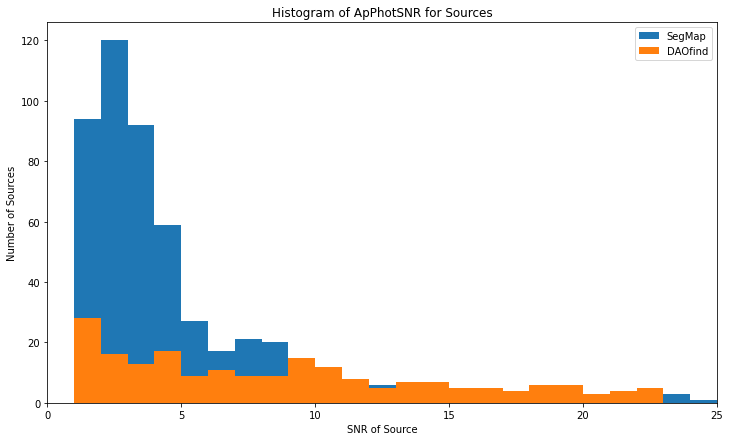

In [17]:
#now lets look at SNR distrobution
binlist=np.linspace(1,50,50)

plt.figure(figsize=(12,7))
plt.title('Histogram of ApPhotSNR for Sources')
plt.hist(mastercatSEG['aper_snr_max'],bins=binlist,label='SegMap')
plt.hist(mastercatDAO['aper_snr_max'],bins=binlist,label='DAOfind')
plt.legend()
plt.xlabel('SNR of Source')
plt.ylabel('Number of Sources')
plt.xlim(0,25)
plt.show()


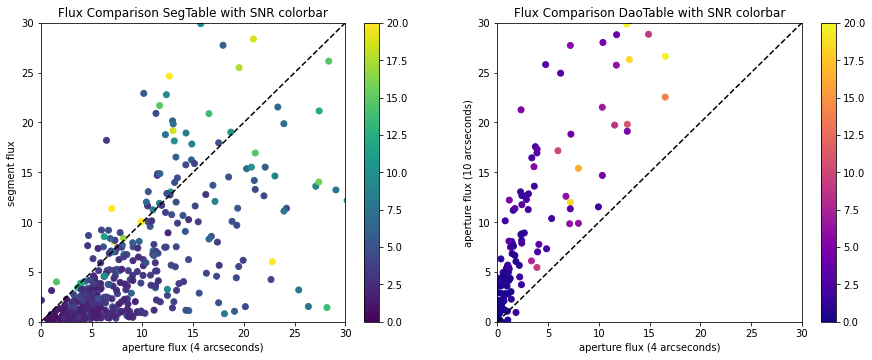

In [18]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison SegTable with SNR colorbar')
p1=ax1.scatter(mastercatSEG['aper_sum_bkgsub_4.0as'],mastercatSEG['segment_flux'],c=mastercatSEG['aper_snr_max'], cmap='viridis',vmin=0,vmax=20)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (4 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)


ax2.set_title('Flux Comparison DaoTable with SNR colorbar')
p2=ax2.scatter(mastercatDAO['aper_sum_bkgsub_4.0as'],mastercatDAO['aper_sum_bkgsub_10as'],c=mastercatDAO['aper_snr_max'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (4 arcseconds)')
ax2.set_ylabel('aperture flux (10 arcseconds)')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)

plt.show()

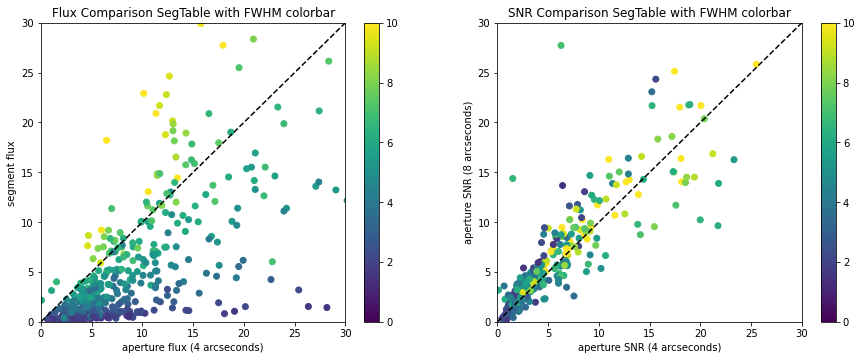

In [19]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison SegTable with FWHM colorbar')
p1=ax1.scatter(mastercatSEG['aper_sum_bkgsub_4.0as'],mastercatSEG['segment_flux'],c=mastercatSEG['fwhm'], cmap='viridis',vmin=0,vmax=10)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (4 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)


ax2.set_title('SNR Comparison SegTable with FWHM colorbar')
p2=ax2.scatter(mastercatSEG['aper_snr_4.0as'],mastercatSEG['aper_snr_10as'],c=mastercatSEG['fwhm'], cmap='viridis',vmin=0,vmax=10)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture SNR (4 arcseconds)')
ax2.set_ylabel('aperture SNR (8 arcseconds)')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)

plt.show()

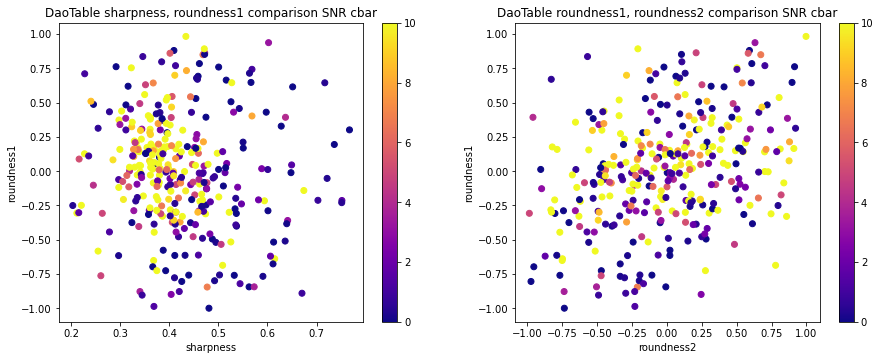

In [20]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('DaoTable sharpness, roundness1 comparison SNR cbar')
p1=ax1.scatter(mastercatDAO['sharpness'],mastercatDAO['roundness1'],c=mastercatDAO['aper_snr_max'], cmap='plasma',vmin=0,vmax=10)
fig.colorbar(p1, ax=ax1)
#ax1.plot([0,3],[0,3],'k--')
ax1.set_xlabel('sharpness')
ax1.set_ylabel('roundness1')
#ax1.set_xlim(0,30)
#ax1.set_ylim(0,30)


ax2.set_title('DaoTable roundness1, roundness2 comparison SNR cbar')
p2=ax2.scatter(mastercatDAO['roundness2'],mastercatDAO['roundness1'],c=mastercatDAO['aper_snr_max'], cmap='plasma',vmin=0,vmax=10)
fig.colorbar(p2, ax=ax2)
#ax2.plot([0,3],[0,3],'k--')
ax2.set_xlabel('roundness2')
ax2.set_ylabel('roundness1')
#ax2.set_xlim(0,30)
#ax2.set_ylim(0,30)

plt.show()

In [21]:
#lets just do a simple SNR cuts for both tables
snrcutSEG=mastercatSEG['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
snrcutDAO=mastercatDAO['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0

mctseg=mastercatSEG[snrcutSEG] #apply snr cut
mctdao=mastercatDAO[snrcutDAO] #apply snr cut

In [22]:
mctseg

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,skycoords,aperture_sum_3.5as,aperture_sum_err_3.5as,aperture_sum_3.75as,aperture_sum_err_3.75as,aperture_sum_4.0as,aperture_sum_err_4.0as,aperture_sum_4.25as,aperture_sum_err_4.25as,aperture_sum_4.5as,aperture_sum_err_4.5as,aperture_sum_4.75as,aperture_sum_err_4.75as,aperture_sum_5.0as,aperture_sum_err_5.0as,aperture_sum_5.25as,aperture_sum_err_5.25as,aperture_sum_5.5as,aperture_sum_err_5.5as,aperture_sum_5.75as,aperture_sum_err_5.75as,aperture_sum_6.0as,aperture_sum_err_6.0as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,pixApArea,pixAnnArea,aper_snr_6as,aper_sum_bkgsub_3.5as,aper_sum_bkgsub_3.75as,aper_sum_bkgsub_4.0as,aper_sum_bkgsub_4.25as,aper_sum_bkgsub_4.5as,aper_sum_bkgsub_4.75as,aper_sum_bkgsub_5.0as,aper_sum_bkgsub_5.25as,aper_sum_bkgsub_5.5as,aper_sum_bkgsub_5.75as,aper_sum_bkgsub_6.0as,aper_sum_bkgsub_10as,aper_snr_3.5as,aper_snr_3.75as,aper_snr_4.0as,aper_snr_4.25as,aper_snr_4.5as,aper_snr_4.75as,aper_snr_5.0as,aper_snr_5.25as,aper_snr_5.5as,aper_snr_5.75as,aper_snr_6.0as,aper_snr_10as,aper_snr_max,Field,wv,Master_id,selfXmatch
,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,str38,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,int32,int32,int32
1,185.7,53.38,"266.3251439751818,-29.07810767850448",0.02809,0.005636,0.2987,53,2.184,1.684,-11.8,0.2156,0.05716,0.3465,0.6365,0.2287,1.297,4.592,8.889,0.4441,2.771,3.334,0.129,0.00554,0.005515,0.001103,5.136,"266.3251439751818,-29.07810767850448",4.064191264362414,0.1436035028599071,4.40512876606941,0.15401058357236383,4.733781464724758,0.1644266879972215,5.045941218469983,0.17484920342436022,5.364082426069148,0.18527479381496464,5.670884510094932,0.19575554331244469,5.97927970441601,0.20629698348008146,6.295254873046549,0.21687134343761783,6.6347027222923955,0.22753232244226068,6.977544186990841,0.23830716271689145,7.320475242706701,0.24914123593798546,11.219713707981342,0.44093325418505575,-0.00110152259003371,-0.001460585809972832,7.531689550356361,0.24914123593798546,0.0,191.747595156624,830.9062456787041,13.60132719014324,4.1360627996043124,4.487634354995059,4.827654490346829,5.151915063801148,5.482890474122081,5.803260143882305,6.125956306950496,6.456965827340819,6.8121814113591235,7.171523993842698,7.531689550356361,11.806420118119286,10.509677032309682,10.952170609196168,11.338304125072453,11.663974357013618,11.9839265226056,12.259765831621918,12.521330180677717,12.781967834534921,13.070097083751321,13.34450623089316,13.60132719014324,13.87950963728634,13.87950963728634,C7FieldA,37,1,0
3,142.0,240.5,"266.33580666298076,-29.038186246908264",0.06869,0.1118,35.33,316,5.051,4.085,-59.43,0.05457,0.01815,0.04456,0.5881,0.1912,1.236,10.82,89.17,0.6031,1.666,62.8,0.32,0.1086,0.1105,0.0115,10.58,"266.33580666298076,-29.038186246908264",27.050376141774574,0.14533024179889445,31.001319380018813,0.155723073919348,35.13099334339175,0.16611544202163334,39.40827371529196,0.17650456927338018,43.797344488691074,0.18689219627806747,48.2711414

In [23]:
mctdao

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,sky_centroid,skycoords,aperture_sum_3.5as,aperture_sum_err_3.5as,aperture_sum_3.75as,aperture_sum_err_3.75as,aperture_sum_4.0as,aperture_sum_err_4.0as,aperture_sum_4.25as,aperture_sum_err_4.25as,aperture_sum_4.5as,aperture_sum_err_4.5as,aperture_sum_4.75as,aperture_sum_err_4.75as,aperture_sum_5.0as,aperture_sum_err_5.0as,aperture_sum_5.25as,aperture_sum_err_5.25as,aperture_sum_5.5as,aperture_sum_err_5.5as,aperture_sum_5.75as,aperture_sum_err_5.75as,aperture_sum_6.0as,aperture_sum_err_6.0as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,pixApArea,pixAnnArea,aper_snr_6as,aper_sum_bkgsub_3.5as,aper_sum_bkgsub_3.75as,aper_sum_bkgsub_4.0as,aper_sum_bkgsub_4.25as,aper_sum_bkgsub_4.5as,aper_sum_bkgsub_4.75as,aper_sum_bkgsub_5.0as,aper_sum_bkgsub_5.25as,aper_sum_bkgsub_5.5as,aper_sum_bkgsub_5.75as,aper_sum_bkgsub_6.0as,aper_sum_bkgsub_10as,aper_snr_3.5as,aper_snr_3.75as,aper_snr_4.0as,aper_snr_4.25as,aper_snr_4.5as,aper_snr_4.75as,aper_snr_5.0as,aper_snr_5.25as,aper_snr_5.5as,aper_snr_5.75as,aper_snr_6.0as,aper_snr_10as,aper_snr_max,Field,wv,Master_id,selfXmatch
,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,str38,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,int32,int32,int32
2,213.4,148.9,0.4518,-0.1732,0.8181,25,0,0.1442,1.076,-0.07969,"266.3183989918721,-29.057733937455602","266.3183989918721,-29.057733937455602",18.734297719120754,0.14816358805970256,21.20770984238869,0.15874357538772235,23.801396378109168,0.16932338698122978,26.508367632892945,0.17990310150893593,29.323747257271005,0.19048076641502518,32.258784999887325,0.20105608012153878,35.28986975428329,0.2116294175824651,38.37882781122658,0.22220078568287677,41.52228558021345,0.23277124067855806,44.73949176145831,0.2433410285109194,48.03156530191408,0.2539122179038373,112.74481233385644,0.42298183947725354,0.11633483320474625,0.13586801740255652,25.724640801957023,0.2539122179038373,0.11633483320474622,191.747595156624,830.9062456787041,4.8818384427350585,11.143747021218697,12.494067459592966,13.887207711461585,15.316178083435325,16.77610222604516,18.27822988793507,19.79894996264644,21.300088740946954,22.778272632332868,24.25275033701858,25.724640801957023,50.781133167309044,3.8572838664421005,4.017368345118288,4.16492414552328,4.299717310826916,4.422176103796042,4.536683879948835,4.6385269933260265,4.720813916238842,4.785459398111001,4.838604024660732,4.8818384427350585,5.018787794494983,5.018787794494983,C7FieldA,37,2,0
3,203.1,170.3,0.4136,-0.09751,0.3496,25,0,0.163,1.197,-0.1955,"266.32089335402253,-29.053166181103368","266.32089335402253,-29.053166181103368",19.976667475004362,0.14731548612197612,22.70332525310486,0.15783930004372715,25.576605963724763,0.16836307983725032,28.593968518514163,0.17888515661687587,31.745743670174335,0.18940507939115772,35.02022002452101,0.19992435548563964,38.41527836872785,0.21044395159469556,41.920281177733116,0.22096254758800773,45.53313721518275,0.23148243847281055,49.2459830202657,0.24200184992477805,53.0714552027411,0.25252136572725853,126.96184767543737,0.42076821677543585,0.13625795414316677,0.14685528165227582,26.944320174827325,0.25252136572725853,0.13625795414316677,191.747595156624,830.9062456787041,4.728728156233069,11.086184028005922,12.497413132826043,13.964545951318641,15.48504139513381,17.049230216972834,18.645401022651434,20.271434599343277,2

In [24]:
#lets see if there are cross matches between the tables
segsources=mctseg['skycoords']
daosources=mctdao['skycoords']

idx,rdx, d2d, d3d = daosources.search_around_sky(segsources, 4*u.arcsec)

print('Number of crossmatched sources found: ', len(idx))



Number of crossmatched sources found:  113


In [25]:
arr1=np.zeros(len(mctseg))
arr2=np.zeros(len(mctdao))

arr1[idx]=1
arr2[rdx]=1

In [26]:
mctseg['catXmatch']=arr1.astype(np.int)
mctdao['catXmatch']=arr2.astype(np.int)

In [27]:
#write 'master' catalogs to files
ascii.write(mctseg,'mcSeg_FFsnr_'+str(wavelength)+'um.dat')
ascii.write(mctdao,'mcDao_FFsnr_'+str(wavelength)+'um.dat')

In [28]:
#write out save ds9 region files

#set size of regions 
r = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"
#write out ds9 files
makeDS9file('mcat_segff_snrcut_'+str(wavelength)+'.reg', mctseg, r, color='cyan')
makeDS9file('mcat_daoff_snrcut_'+str(wavelength)+'.reg', mctdao, r, color='yellow')

In [29]:
#lets save another region file for sources that pass the snr cut and are found by both daofind and segmap
cmatchcut=mctdao['catXmatch']==1
crossmatchcat=mctdao[cmatchcut]

makeDS9file('mcat_snrcut_both_'+str(wavelength)+'.reg', crossmatchcat, r, color='green')